# How many zero and low emissions vehicles are registered in California?

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from pywaffle import Waffle
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:,.2f}'.format
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
# CARB looks for ways to meet our 5 million zero-emission vehicle target by 2030, the conversion of public and private fleets to zero emission cars and trucks offers an important opportunity to get a large number of carbon-polluting fleet vehicles off the road.
# https://ww2.arb.ca.gov/sites/default/files/2018-12/zero_emission_fleet_letter_080118.pdf

### Read data from California Department of Motor Vehicles - current as of October 2018

In [3]:
# https://data.ca.gov/dataset/vehicle-fuel-type-count-by-zip-code
src = pd.read_csv('/Users/mhustiles/data/data/fuel/vehicle-fuel-type-count-by-zip-code.csv', low_memory=False)

### Clean up field names

In [4]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [5]:
src.rename(columns={"zip_code": "zip"}, inplace=True)

### How many vehicles are we talking about? 

In [6]:
'{:,.0f}'.format(src.vehicles.sum())

'31,137,994'

### Remove few 2019 models, older models and those listed as out of state. Also remove heavy duty.

In [7]:
vehicles = pd.DataFrame(src[(src['model_year'] != '2019') &\
          (src['model_year'] != '<2006') &\
          (src['zip'] != 'OOS')&\
        (src['duty'] != 'Heavy')
                           ])

In [8]:
all_vehicles = pd.DataFrame(src)

In [9]:
len(vehicles)

440177

### What's left?

In [10]:
'{:,.0f}'.format(vehicles.vehicles.sum())

'18,911,128'

### How many don't rely solely on gasoline?

In [11]:
nogas = vehicles[(vehicles['fuel'] != 'Gasoline')]

In [12]:
zev = vehicles[vehicles['fuel'] == 'Battery Electric']

In [13]:
cvrp = vehicles[(vehicles['fuel'] == 'Battery Electric') |\
               (vehicles['fuel'] == 'Hydrogen Fuel Cell') |\
              (vehicles['fuel'] == 'Plug-in Hybrid')]

In [14]:
'{:,.0f}'.format(nogas.vehicles.sum())

'2,735,932'

### How many are battery electric, or otherwise CVRP eligible?

In [15]:
'{:,.0f}'.format(cvrp.vehicles.sum())

'421,117'

In [16]:
'{:,.0f}'.format(zev.vehicles.sum())

'214,056'

### Share of newer CA vehicles that don't rely solely on gas?

In [17]:
'{:,.1f}%'.format((nogas.vehicles.sum() / vehicles.vehicles.sum())*100)

'14.5%'

### Share of CA vehicles that are battery electric, or otherwise CVRP eligible?

In [18]:
'{:,.1f}%'.format((cvrp.vehicles.sum() / vehicles.vehicles.sum())*100)

'2.2%'

---

### ZIP code points

In [19]:
zips_point = gpd.read_file('/Users/mhustiles/data/data/GIS/zipcodes.geojson')

In [20]:
zips_point['zip'] = zips_point['zip'].astype(str)

In [21]:
ca_zips_point = zips_point[zips_point['state'] == 'CA']

### ZIP code boundaries

In [22]:
# Filtered CA from this national file maintained by Esri: 
# https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_ZIP_Code_Areas_anaylsis/FeatureServer/0/
zips_poly_pop = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri.geojson')
zips_poly = gpd.read_file('/Users/mhustiles/data/data/GIS/ca-zip-codes-esri-demographics.geojson')

In [23]:
zips_poly.columns = zips_poly.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [24]:
zips_poly.dropna(inplace=True)

In [25]:
zips_poly.rename(columns={"zip_code": "zip"}, inplace=True)

In [26]:
zips_poly.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.277034540571 37.5343582023783, ..."
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.60,2.43,4798,12179,3.06,20020,13.00,"POLYGON ((-122.377279066574 37.6056199838047, ..."
2,4900,93442,Morro Bay,10873,9395,47,104,281,10,1602,645,322,48.90,2.09,593,2749,2.70,6609,43.20,"POLYGON ((-120.772553656772 35.4619572932372, ..."
3,4901,93445,Oceano,7633,4683,60,114,155,7,3389,1477,283,34.70,2.86,541,1582,3.42,2871,2.00,"POLYGON ((-120.63623999603 35.1221336393226, -..."
4,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.00,3.10,4637,13991,3.54,20103,5.70,"POLYGON ((-122.502826389233 37.7081318430574, ..."


---

### Zipcode demographics from mapping giant Esri

In [27]:
#https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/WealthiestZipCodes2017/FeatureServer/0/
zips_wealth = gpd.read_file('/Users/mhustiles/data/github/AGStoShapefile/\
backupdir/WealthiestZipCodes2017/WealthiestZipCodesCA.geojson')

In [28]:
zips_wealth.head()

,OBJECTID,ID,NAME,ST_ABBREV,HAI_CY,INCMORT_CY,WLTHRNK_CY,DOMSTATE,DOMCOUNTY,COUNTY_NAME,DOMCBSA,CBSA_NAME,TOTPOP_CY,TOTHH_CY,MEDAGE_CY,AVGHINC_CY,AVGVAL_CY,AVGNW_CY,Shape__Area,Shape__Length,geometry
0,29014,90001,Los Angeles,CA,55,44.10,"27,675.00",06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",59907,13454,27.10,46931,377591,82915,"12,747,932.74","17,936.35","POLYGON ((-118.247540000384 33.9890800002533, ..."
1,29015,90002,Los Angeles,CA,59,41.20,"27,690.00",06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",53573,12115,26.70,46332,331694,96786,"11,348,270.82","16,650.99","POLYGON ((-118.247449999972 33.9601500002775, ..."
2,29016,90003,Los Angeles,CA,52,46.60,"28,202.00",06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",71967,16771,27.10,43020,358057,66091,"13,659,740.57","23,821.37","(POLYGON ((-118.282680000326 33.9892600000928,..."
3,29017,90004,Los Angeles,CA,21,114.50,"20,202.00",06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",63987,23021,35.80,65893,909580,232653,"10,904,998.97","22,878.23","(POLYGON ((-118.338519995327 34.0689099997087,..."
4,29018,90005,Los Angeles,CA,22,111.50,"26,028.00",06,06037,Los Angeles County,31080,"Los Angeles-Long Beach-Anaheim, CA Metropolita...",41844,17067,35.80,53191,836569,105569,"5,390,883.48","19,394.84","POLYGON ((-118.318789991455 34.0551400002875, ..."


In [29]:
zips_wealth_slim = zips_wealth[['ID','NAME', 'AVGHINC_CY', 'AVGNW_CY', 'TOTPOP_CY', 'geometry']]

In [30]:
zips_esri = zips_wealth_slim.rename(columns={"ID": "zip",
                                                    'NAME':'name',
                                 'AVGHINC_CY':'avg_house_income',
                                 'AVGNW_CY':'avg_net_worth',
                                 'TOTPOP_CY':'population', })

In [31]:
zips_esri.head()

,zip,name,avg_house_income,avg_net_worth,population,geometry
0,90001,Los Angeles,46931,82915,59907,"POLYGON ((-118.247540000384 33.9890800002533, ..."
1,90002,Los Angeles,46332,96786,53573,"POLYGON ((-118.247449999972 33.9601500002775, ..."
2,90003,Los Angeles,43020,66091,71967,"(POLYGON ((-118.282680000326 33.9892600000928,..."
3,90004,Los Angeles,65893,232653,63987,"(POLYGON ((-118.338519995327 34.0689099997087,..."
4,90005,Los Angeles,53191,105569,41844,"POLYGON ((-118.318789991455 34.0551400002875, ..."


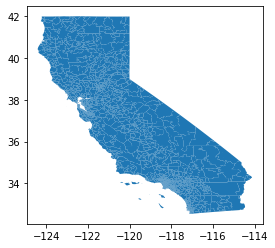

In [32]:
zips_esri.plot()

---

### Group the vehicles and count them by the registration ZIP code

In [33]:
zipcodes = vehicles.groupby(['zip']).agg({'vehicles':'sum'}).reset_index()

In [34]:
zipcodes.sort_values(by='vehicles', ascending=False).head(10)
zipcodes['zip'] = zipcodes['zip'].astype(str)

### Merge the registration zip codes and merge with Esri zipcode polygons

In [35]:
zips = pd.merge(zips_esri, zipcodes, left_on='zip', right_on='zip')

In [36]:
zips.head()

,zip,name,avg_house_income,avg_net_worth,population,geometry,vehicles
0,90001,Los Angeles,46931,82915,59907,"POLYGON ((-118.247540000384 33.9890800002533, ...",16753
1,90002,Los Angeles,46332,96786,53573,"POLYGON ((-118.247449999972 33.9601500002775, ...",15328
2,90003,Los Angeles,43020,66091,71967,"(POLYGON ((-118.282680000326 33.9892600000928,...",20006
3,90004,Los Angeles,65893,232653,63987,"(POLYGON ((-118.338519995327 34.0689099997087,...",22857
4,90005,Los Angeles,53191,105569,41844,"POLYGON ((-118.318789991455 34.0551400002875, ...",12343


---

### Group by duty. Which are most common among ALL vehicles? 

In [37]:
# About 2.5 are listed as OTHER/UNK
duty_totals = all_vehicles.groupby(['duty']).agg('sum').reset_index()
duty_totals.head()

,duty,vehicles
0,Heavy,1050878
1,Light,30087116


### Group by make. Which are most common? 

In [38]:
# About 2.5 are listed as OTHER/UNK
make = vehicles[vehicles['make'] != 'OTHER/UNK'].groupby(['make', 'zip']).agg('sum').reset_index()

In [39]:
most_make = make.groupby(['make']).agg('sum').reset_index().sort_values(by='vehicles', ascending=False)

In [40]:
most_make.head()

,make,vehicles
54,TOYOTA,3477549
24,HONDA,2324083
19,FORD,1594865
10,CHEVROLET,1342183
41,NISSAN,1326031


In [41]:
makelist = most_make.make.to_list()

In [42]:
popular_makes = make[make['make'].isin(makelist)]

In [43]:
make_zip = pd.DataFrame(pd.pivot_table(popular_makes, values='vehicles', \
                            index=['zip'], columns=['make'], aggfunc=np.sum, fill_value=0).reset_index())

In [44]:
make_zip.columns = make_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which make is most common in each ZIP code? 

In [45]:
make_zip["total"] = make_zip.sum(axis=1)

In [46]:
make_zip.sort_values(by='total', ascending=False).head(5)

make,zip,acura,alfa_romeo,am_general,american_custom_golfcarts,aston_martin,audi,bentley,bmw,buick,cadillac,chevrolet,chrysler,club_car,columbia,dodge,dymac_vehicle_group_inc,ezgo,ferrari,fiat,ford,freightliner,gem,genesis,gmc,...,mazda,mercedes_benz,mercury,miles,mini,mitsubishi,nissan,pontiac,porsche,ram,rolls_royce,saab,saturn,scion,smart,subaru,suzuki,tesla,tomberlin,toyota,volkswagen,volvo,vpg,workhorse,total
43,90045,322,0,0,0,0,705,0,1350,851,655,9457,3133,0,0,7989,0,0,0,128,18174,0,0,0,1530,...,3338,1974,0,0,225,2070,19787,0,206,759,0,0,12,120,0,635,0,178,0,17541,3921,298,0,0,124765
963,94080,760,0,0,0,0,456,0,1291,1058,337,10800,2139,0,0,1506,0,0,0,35,10426,0,0,0,754,...,1895,1845,0,0,234,102,21543,45,139,374,0,0,43,376,11,1937,0,147,0,18353,1400,72,0,0,100079
492,92336,453,0,0,0,0,438,0,1466,172,438,5862,637,0,0,1361,0,0,0,70,3969,0,0,0,618,...,870,1497,0,0,209,269,5600,57,0,352,0,0,102,759,0,466,0,34,0,9449,771,84,0,0,50605
260,91709,801,18,0,0,0,654,0,2378,72,364,2924,291,0,0,611,0,0,0,84,3528,0,0,25,452,...,1084,2798,0,0,277,151,2351,0,305,213,0,0,49,476,0,798,0,269,0,9229,916,196,0,0,46030
133,90650,485,0,0,0,0,318,0,1029,97,211,3780,560,0,0,1483,0,0,0,33,3056,0,0,0,705,...,789,798,13,0,149,270,4309,60,65,282,0,0,147,982,0,355,0,18,0,10074,665,24,0,0,44862


In [47]:
make_zip.columns

Index(['zip', 'acura', 'alfa_romeo', 'am_general', 'american_custom_golfcarts',
       'aston_martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac',
       'chevrolet', 'chrysler', 'club_car', 'columbia', 'dodge',
       'dymac_vehicle_group_inc', 'ezgo', 'ferrari', 'fiat', 'ford',
       'freightliner', 'gem', 'genesis', 'gmc', 'honda', 'hummer', 'hyundai',
       'infiniti', 'jaguar', 'jeep', 'kia', 'land_rover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mercedes_benz', 'mercury', 'miles', 'mini',
       'mitsubishi', 'nissan', 'pontiac', 'porsche', 'ram', 'rolls_royce',
       'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla',
       'tomberlin', 'toyota', 'volkswagen', 'volvo', 'vpg', 'workhorse',
       'total'],
      dtype='object', name='make')

In [48]:
make_zip[['zip', 'total']].to_csv('output/total_makes_zip.csv')

In [49]:
make_total = pd.DataFrame(make_zip[['zip', 'total']])

In [50]:
make_zip['winner'] = make_zip[['acura', 'alfa_romeo', 'am_general', 'american_custom_golfcarts',
       'aston_martin', 'audi', 'bentley', 'bmw', 'buick', 'cadillac',
       'chevrolet', 'chrysler', 'club_car', 'columbia', 'dodge',
       'dymac_vehicle_group_inc', 'ezgo', 'ferrari', 'fiat', 'ford',
       'freightliner', 'gem', 'genesis', 'gmc', 'honda', 'hummer', 'hyundai',
       'infiniti', 'jaguar', 'jeep', 'kia', 'land_rover', 'lexus', 'lincoln',
       'maserati', 'mazda', 'mercedes_benz', 'mercury', 'miles', 'mini',
       'mitsubishi', 'nissan', 'pontiac', 'porsche', 'ram', 'rolls_royce',
       'saab', 'saturn', 'scion', 'smart', 'subaru', 'suzuki', 'tesla',
       'tomberlin', 'toyota', 'volkswagen', 'volvo', 'vpg', 'workhorse']].idxmax(axis=1)

In [51]:
make_zip.head(10)

make,zip,acura,alfa_romeo,am_general,american_custom_golfcarts,aston_martin,audi,bentley,bmw,buick,cadillac,chevrolet,chrysler,club_car,columbia,dodge,dymac_vehicle_group_inc,ezgo,ferrari,fiat,ford,freightliner,gem,genesis,gmc,...,mercedes_benz,mercury,miles,mini,mitsubishi,nissan,pontiac,porsche,ram,rolls_royce,saab,saturn,scion,smart,subaru,suzuki,tesla,tomberlin,toyota,volkswagen,volvo,vpg,workhorse,total,winner
0,90001,64,0,0,0,0,0,0,328,0,92,1736,287,0,0,705,0,0,0,0,1041,0,0,0,175,...,174,0,0,15,0,2557,43,0,83,0,0,33,311,0,35,0,0,0,3119,191,0,0,0,15356,toyota
1,90002,46,0,0,0,0,0,0,225,0,73,1619,291,0,0,684,0,0,0,0,886,0,0,0,120,...,160,0,0,0,40,2392,37,0,38,0,0,37,283,0,13,0,0,0,2891,225,0,0,0,14062,toyota
2,90003,92,0,0,0,0,35,0,372,23,80,1913,378,0,0,792,0,0,0,0,1183,0,0,0,168,...,292,0,0,11,53,3104,56,0,50,0,0,42,408,0,24,0,0,0,4053,255,0,0,0,18769,toyota
3,90004,245,12,0,0,0,549,0,1048,12,41,722,52,0,0,193,0,0,0,122,852,0,0,12,0,...,943,0,0,261,83,1866,0,92,0,0,0,0,303,0,320,0,97,0,5588,671,98,0,0,21260,toyota
4,90005,93,0,0,0,0,225,0,717,0,0,288,19,0,0,25,0,0,0,25,333,0,0,0,0,...,641,0,0,79,0,895,0,46,0,0,0,0,66,0,145,0,16,0,2804,307,12,0,0,10930,toyota
5,90006,81,0,0,0,0,123,0,562,0,0,743,59,0,0,214,0,0,0,31,649,0,0,0,0,...,463,0,0,65,13,1999,0,0,0,0,0,11,236,0,106,0,0,0,4531,292,0,0,0,15609,toyota
6,90007,17,0,0,0,0,185,0,440,0,0,628,74,0,0,197,0,0,0,0,611,0,0,0,0,...,269,0,0,52,0,1178,0,41,0,0,0,0,105,0,74,0,0,0,2223,348,0,0,0,9330,toyota
7,90008,24,0,0,0,0,175,0,518,28,182,820,186,0,0,300,0,0,0,13,617,0,0,0,51,...,742,0,0,43,0,1126,33,0,0,0,0,0,51,0,68,0,30,0,1785,319,27,0,0,10585,toyota
8,90009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,11,toyota
9,90010,0,0,0,0,0,78,0,316,0,65,132,0,0,0,70,0,0,0,0,516,0,0,0,25,...,701,0,0,0,0,109,0,120,0,0,0,0,0,0,0,0,46,0,1477,30,48,0,0,4733,toyota


In [52]:
make_zip_top_ten = pd.DataFrame(make_zip[['zip','toyota','honda','ford','chevrolet','nissan',\
                               'bmw','hyundai','lexus','mercedes_benz','kia', 'total']])

In [53]:
make_zip_top_ten.to_csv('output/make_zip_top_ten.csv')

In [54]:
make_zip_top_ten.head()

make,zip,toyota,honda,ford,chevrolet,nissan,bmw,hyundai,lexus,mercedes_benz,kia,total
0,90001,3119,2189,1041,1736,2557,328,329,154,174,1014,15356
1,90002,2891,1843,886,1619,2392,225,309,174,160,1101,14062
2,90003,4053,2570,1183,1913,3104,372,394,212,292,1348,18769
3,90004,5588,3249,852,722,1866,1048,810,1197,943,655,21260
4,90005,2804,1804,333,288,895,717,662,851,641,375,10930


---

## Isolate vehicle makes to include only Teslas

In [55]:
tesla = vehicles[(vehicles['make'] == 'TESLA')]

In [56]:
len(tesla)

2211

### Group by ZIP code and count the vehicles

In [57]:
tesla_grouped = tesla.groupby(['zip']).agg({'vehicles':'sum'}).reset_index()

### Merge with dataframe that includes all vehicle counts by ZIP code

In [58]:
tesla_zips = pd.merge(tesla_grouped, zips, on='zip')

### Rename the columns

In [59]:
tesla_zips.rename(columns={'median': 'income','zip': 'zip', \
                           'vehicles_x':'teslas', 'vehicles_y':'all_vehicles'}, inplace=True)

### Normalize Tesla ownership to a rate per 1,000 vehicles

In [60]:
tesla_zips['tesla_rate_1k'] = ((tesla_zips.teslas / tesla_zips.all_vehicles) * 1000).round(2)

In [61]:
tesla_zips.sort_values(by='tesla_rate_1k', ascending=False).head(10)

,zip,teslas,name,avg_house_income,avg_net_worth,population,geometry,all_vehicles,tesla_rate_1k
453,94027,420,Atherton,297732,3680197,7230,"POLYGON ((-122.186370000193 37.4766900005567, ...",5140,81.71
450,94022,934,Los Altos,248970,3041961,20626,"(POLYGON ((-122.182210000029 37.3267800008013,...",13818,67.59
494,94301,584,Palo Alto,224861,1760729,18694,"(POLYGON ((-122.153900000786 37.4349899998026,...",9504,61.45
339,92657,459,Newport Coast,244565,2836260,11464,"POLYGON ((-117.838300000494 33.6300500021121, ...",8302,55.29
454,94028,254,Portola Valley,263238,3322715,6639,"(POLYGON ((-122.196020000317 37.3404300000868,...",4829,52.60
451,94024,773,Los Altos,259185,3442702,23198,"POLYGON ((-122.06022998857 37.328550002215, -1...",14953,51.70
615,95070,1065,Saratoga,243915,3157204,32730,"(POLYGON ((-122.033300000694 37.2178000012605,...",21427,49.70
603,95030,423,Los Gatos,233429,2476366,13618,"(POLYGON ((-121.953019999983 37.2105900005357,...",9328,45.35
37,90067,162,Los Angeles,180115,2157237,2823,"POLYGON ((-118.413749999802 34.0634800001152, ...",3774,42.93
535,94555,817,Fremont,138683,991742,37315,"(POLYGON ((-122.074109999622 37.5301999994016,...",19522,41.85


In [62]:
tesla_breaks \
= jenkspy.jenks_breaks(tesla_zips.tesla_rate_1k, nb_class=6)
tesla_breaks

[0.28, 5.07, 11.82, 20.5, 30.74, 45.35, 81.71]

In [63]:
tesla_zips.to_csv('output/tesla_zips.csv')

In [64]:
tesla_zips_slim = pd.DataFrame(tesla_zips[['zip','name','teslas','all_vehicles','tesla_rate_1k', 'avg_house_income', 'avg_net_worth']])

In [65]:
tesla_zips_slim.sort_values(by='tesla_rate_1k', ascending=False).head(10)

,zip,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
453,94027,Atherton,420,5140,81.71,297732,3680197
450,94022,Los Altos,934,13818,67.59,248970,3041961
494,94301,Palo Alto,584,9504,61.45,224861,1760729
339,92657,Newport Coast,459,8302,55.29,244565,2836260
454,94028,Portola Valley,254,4829,52.60,263238,3322715
451,94024,Los Altos,773,14953,51.70,259185,3442702
615,95070,Saratoga,1065,21427,49.70,243915,3157204
603,95030,Los Gatos,423,9328,45.35,233429,2476366
37,90067,Los Angeles,162,3774,42.93,180115,2157237
535,94555,Fremont,817,19522,41.85,138683,991742


### How predictive is income  

In [66]:
tesla_zips.head()

,zip,teslas,name,avg_house_income,avg_net_worth,population,geometry,all_vehicles,tesla_rate_1k
0,90004,97,Los Angeles,65893,232653,63987,"(POLYGON ((-118.338519995327 34.0689099997087,...",22857,4.24
1,90005,16,Los Angeles,53191,105569,41844,"POLYGON ((-118.318789991455 34.0551400002875, ...",12343,1.30
2,90008,30,Los Angeles,56286,284531,34600,"POLYGON ((-118.322510000162 34.0185100009328, ...",12281,2.44
3,90010,46,Los Angeles,53753,59071,496,"(POLYGON ((-118.314369999758 34.0609200019465,...",5912,7.78
4,90012,57,Los Angeles,51188,68935,35157,"POLYGON ((-118.23956999986 34.0909100012498, -...",17647,3.23


In [67]:
tesla_zips_corr = tesla_zips_slim[['tesla_rate_1k', 'avg_house_income']]

In [68]:
corr = tesla_zips_corr.corr(method ='pearson')

In [69]:
print(corr)

                  tesla_rate_1k  avg_house_income
tesla_rate_1k              1.00              0.82
avg_house_income           0.82              1.00


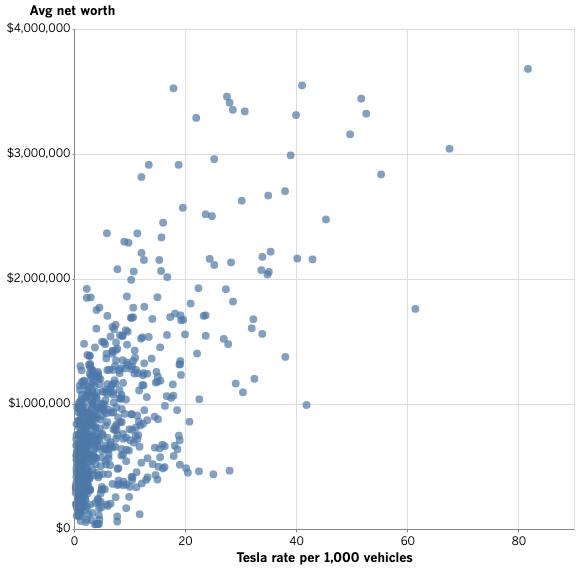

In [70]:
alt.Chart(tesla_zips_slim).mark_circle(size=60).encode(
    x=alt.X('tesla_rate_1k:Q', title='Tesla rate per 1,000 vehicles', axis=alt.Axis(tickCount=6)),
    y=alt.Y('avg_net_worth:Q', title='Avg net worth', axis=alt.Axis(tickCount=5, format='$,N')),
    tooltip=['zip:N', 'teslas:O', 'avg_net_worth:Q', 'tesla_rate_1k:Q']
).properties(width=500, height=500)

In [71]:
tesla_zips_slim.to_csv('output/tesla_zips_slim.csv')

---

### Group by model year. Which years have the most vehicles? 

In [72]:
model_year = vehicles.groupby(['model_year']).agg('sum').reset_index()

In [73]:
model_year.sort_values(by='model_year', ascending=False)

,model_year,vehicles
12,2018,1538408
11,2017,2089615
10,2016,2012281
9,2015,1946304
8,2014,1632312
7,2013,1598828
6,2012,1305180
5,2011,1065573
4,2010,973005
3,2009,802879


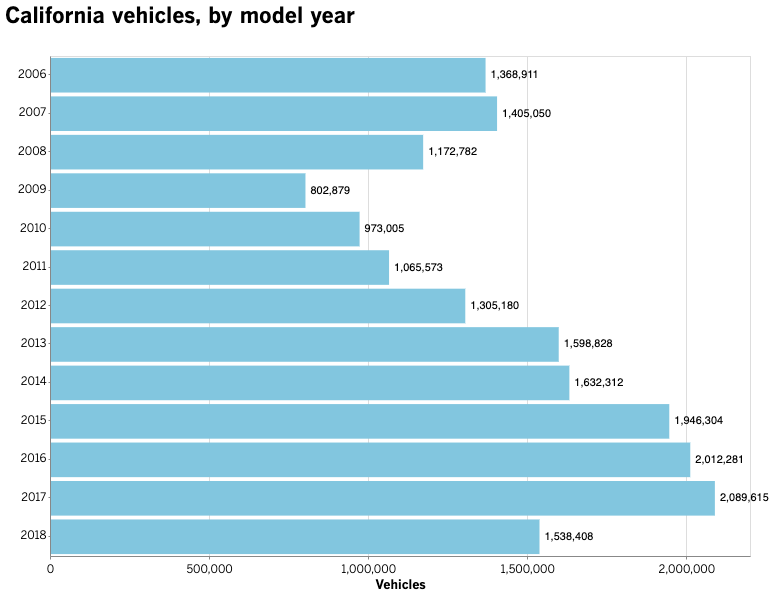

In [74]:
model_year_chart = alt.Chart(model_year).mark_bar().encode(
).mark_bar().encode(
    y=alt.Y('model_year:N', title=" ", axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("vehicles:Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

model_year_chart_text = model_year_chart.mark_text(
    align='left',
    baseline='middle',
    dx=5
).encode(text=alt.Text('vehicles:Q', format=',')
)

(model_year_chart + model_year_chart_text).properties(height=500, \
                                                      width=700, title='California vehicles, by model year')

### Export model year table for graphics

In [75]:
model_year.to_csv('output/model_year.csv')

---

## Fuel types

### Which types of alternative fuel models are most common?

In [76]:
fuel = vehicles.groupby(['fuel']).agg('sum').reset_index()

In [77]:
fuel.head(9)

,fuel,vehicles
0,Battery Electric,214056
1,Diesel and Diesel Hybrid,319455
2,Flex-Fuel,993727
3,Gasoline,16175196
4,Hybrid Gasoline,994696
5,Hydrogen Fuel Cell,5092
6,Natural Gas,6569
7,Other,368
8,Plug-in Hybrid,201969


In [78]:
fuel.fuel.tolist()

['Battery Electric',
 'Diesel and Diesel Hybrid',
 'Flex-Fuel',
 'Gasoline',
 'Hybrid Gasoline',
 'Hydrogen Fuel Cell',
 'Natural Gas',
 'Other',
 'Plug-in Hybrid']

In [79]:
# Diesel and Diesel Hybrid + Flex-Fuel + Gasoline + Hybrid Gasoline
'{:,.0f}'.format((fuel.iloc[1,1] + fuel.iloc[2,1] + fuel.iloc[3,1] + fuel.iloc[4,1]))

'18,483,074'

# Chart the fuel type counts

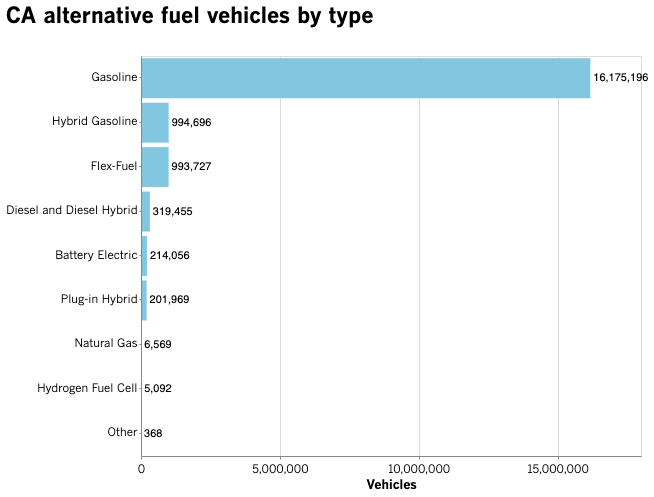

In [80]:
chart_fuels = alt.Chart(fuel).mark_bar().encode(
    y=alt.Y('fuel:N', title=' ',
        sort=alt.EncodingSortField(
            field="vehicles",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        ), axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("sum(vehicles):Q", title="Vehicles", axis=alt.Axis(format='', tickCount=5))
)

chart_fuels_text = chart_fuels.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(text=alt.Text('sum(vehicles)', format=',')
)


(chart_fuels + chart_fuels_text)\
.properties(height=400, width=500, title='CA alternative fuel vehicles by type')

### Export fuel type count table for graphics

In [81]:
fuel.to_csv('output/fuel.csv')

--- 

## Where are these vehicles?

In [82]:
zip_code = vehicles.groupby(['zip']).agg('sum').reset_index()

In [83]:
zip_code_zev = zev.groupby(['zip']).agg('sum').reset_index()

### Which ZIP codes have the most alternative fuel vehicles? (Airport areas, it seems)

In [84]:
zip_code_zev.sort_values(by='vehicles',\
    ascending=False).head(10)

,zip,vehicles
1190,94539,2242
1343,95014,1969
1380,95070,1599
1203,94555,1477
1394,95120,1415
1104,94087,1389
1215,94568,1382
1075,94025,1314
1189,94538,1299
1355,95035,1243


### Pivot on ZIP code and widen out the dataframe to count vehicle types across them

In [85]:
sum_by_zip = pd.pivot_table(vehicles, values='vehicles', \
                            index=['zip'], columns=['fuel'], aggfunc=np.sum, fill_value=0).reset_index()

sum_by_zip.columns = sum_by_zip.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

### Which type is most common in each ZIP code? 

In [86]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [87]:
sum_by_zip.sort_values(by='total', ascending=False).head(5)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,hydrogen_fuel_cell,natural_gas,other,plug_in_hybrid,total
45,90045,408,199,11964,108854,4466,19,9,0,384,126303
1520,94080,307,315,3707,92128,4872,9,4,2,239,101583
782,92336,180,632,2638,46316,1736,7,30,0,443,51982
426,91709,533,637,1822,41512,2389,36,29,1,717,47676
191,90650,129,300,2070,42071,1446,5,13,1,251,46286


### Group the lesser-used fuel types into an 'other' category

In [88]:
sum_by_zip['other'] = sum_by_zip.apply\
    (lambda x: x['hydrogen_fuel_cell'] + x['natural_gas'] + x['other'], axis=1)
sum_by_zip.drop(['hydrogen_fuel_cell', 'natural_gas'], axis=1, inplace=True)
sum_by_zip.drop([0], inplace=True)

### Which non-gas vehicle is most popular — the 'winner' — in each zip?

In [89]:
sum_by_zip['winner'] = \
sum_by_zip[['hybrid_gasoline','battery_electric','diesel_and_diesel_hybrid',\
                   'flex_fuel','plug_in_hybrid', 'other']].idxmax(axis=1)

In [90]:
sum_by_zip.sort_values(by='total', ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner
45,90045,408,199,11964,108854,4466,28,384,126303,flex_fuel
1520,94080,307,315,3707,92128,4872,15,239,101583,hybrid_gasoline
782,92336,180,632,2638,46316,1736,37,443,51982,flex_fuel
426,91709,533,637,1822,41512,2389,66,717,47676,hybrid_gasoline
191,90650,129,300,2070,42071,1446,19,251,46286,flex_fuel
660,92154,115,388,2125,42154,1256,4,140,46182,flex_fuel
979,92683,331,333,1325,41058,2175,39,411,45672,hybrid_gasoline
908,92592,254,1083,2421,38509,2188,15,479,44949,flex_fuel
341,91342,160,563,2272,39097,1858,10,310,44270,flex_fuel
427,91710,284,803,2759,37702,1494,25,464,43531,flex_fuel


### De-slugify the 'winner' category

In [91]:
sum_by_zip['winner'] = sum_by_zip['winner'].str.replace('_', ' ', regex=False).str.capitalize()

In [92]:
sum_by_zip['altshare'] = (((sum_by_zip['total']-sum_by_zip['gasoline'])/sum_by_zip['total'])*100).round()

In [93]:
sum_by_zip['batteryshare'] = ((sum_by_zip['battery_electric']/sum_by_zip['total'])*100)

In [94]:
sum_by_zip.sort_values(by='batteryshare', ascending=False).head(10)

fuel,zip,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner,altshare,batteryshare
405,91522,65,0,0,6,1,0,0,72,Battery electric,92.00,90.28
610,92096,28,0,2,8,0,0,0,38,Battery electric,79.00,73.68
1895,95192,20,0,6,6,0,0,0,32,Battery electric,81.00,62.50
609,92093,380,2,54,213,89,14,6,758,Battery electric,72.00,50.13
1480,94003,39,0,0,41,7,0,8,95,Battery electric,57.00,41.05
87,90095,211,2,244,194,32,15,5,703,Flex fuel,72.00,30.01
2335,95929,16,2,17,27,0,0,0,62,Flex fuel,56.00,25.81
2890,99709,3,0,0,6,3,0,0,12,Hybrid gasoline,50.00,25.00
867,92521,35,2,28,66,13,0,0,144,Battery electric,54.00,24.31
959,92658,188,8,39,545,33,0,12,825,Battery electric,34.00,22.79


### Use the "jenks" method to set fair breaks for total field

In [95]:
breaks \
= jenkspy.jenks_breaks(sum_by_zip.batteryshare, nb_class=7)

In [96]:
breaks

[0.0,
 0.9989162700843425,
 3.214285714285714,
 7.6923076923076925,
 16.43835616438356,
 30.014224751066855,
 62.5,
 90.27777777777779]

---

### Export merged polygon geodataframe as GeoJSON

In [97]:
zips_poly.to_file('/Users/mhustiles/data/data/GIS/zips_poly.geojson', driver='GeoJSON')

In [98]:
zips_poly_merged = zips_poly.merge(sum_by_zip, on='zip')

In [99]:
zips_poly_merged.columns

Index(['objectid', 'zip', 'po_name', 'pop2012', 'white', 'black', 'ameri_es',
       'asian', 'hawn_pi', 'hispanic', 'other_x', 'mult_race', 'med_age',
       'ave_hh_sz', 'marhh_chd', 'families', 'ave_fam_sz', 'hse_units', 'sqmi',
       'geometry', 'battery_electric', 'diesel_and_diesel_hybrid', 'flex_fuel',
       'gasoline', 'hybrid_gasoline', 'other_y', 'plug_in_hybrid', 'total',
       'winner', 'altshare', 'batteryshare'],
      dtype='object')

In [100]:
# zips_poly_merged_drop = ['objectid', 'zip', 'po_name', 'sqmi', 
#                         'battery_electric', 'diesel_and_diesel_hybrid', 'flex_fuel',
#                          'gasoline', 'hybrid_gasoline', 'other_y', 'plug_in_hybrid', 'total',
#                          'winner', 'altshare']
# zips_poly_merged.drop(zips_poly_merged_drop, inplace=True, axis=1)

In [101]:
zips_poly_merged.to_file('/Users/mhustiles/data/data/GIS/zips_poly_merged.geojson', driver='GeoJSON')

### Export with Tesla totals

In [102]:
tesla_zips_poly_merged = zips_poly.merge(tesla_zips_slim, on='zip')

In [103]:
tesla_zips_poly_merged.to_file('/Users/mhustiles/data/github/notebooks/\
california-fuel-vehicles/output/tesla_zips.geojson', driver='GeoJSON')

In [104]:
tesla_zips_poly_merged.head()

,objectid,zip,po_name,pop2012,white,black,ameri_es,asian,hawn_pi,hispanic,other,mult_race,med_age,ave_hh_sz,marhh_chd,families,ave_fam_sz,hse_units,sqmi,geometry,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
0,4800,94002,Belmont,26832,19634,477,84,5762,221,3517,1170,1744,41.00,2.42,2925,7671,2.98,12304,5.90,"POLYGON ((-122.277034540571 37.5343582023783, ...",Belmont,305,15979,19.09,153464,1318219
1,4801,94010,Burlingame,41102,31610,482,93,10244,188,5133,1865,2166,42.60,2.43,4798,12179,3.06,20020,13.00,"POLYGON ((-122.377279066574 37.6056199838047, ...",Burlingame,797,34148,23.34,182761,1704921
2,4802,94015,Daly City,61575,14279,2138,168,35940,482,9775,4520,2939,39.00,3.10,4637,13991,3.54,20103,5.70,"POLYGON ((-122.502826389233 37.7081318430574, ...",Daly City,79,29914,2.64,101482,696394
3,4803,94019,Half Moon Bay,18476,14195,137,128,718,20,5533,2646,693,42.30,2.75,1729,4653,3.23,7132,73.10,"(POLYGON ((-122.428748182297 37.6041545461498,...",Half Moon Bay,86,8880,9.68,151305,1312367
4,4902,93446,Paso Robles,44990,35268,719,465,721,68,12245,4582,1602,38.60,2.67,3930,11561,3.10,18303,344.40,"POLYGON ((-121.060394531453 35.7388181902079, ...",Paso Robles,21,23400,0.90,89608,814803


### Merge ZIP points with Tesla & electric totals

In [105]:
teslas_poimt_merged = ca_zips_point.merge(tesla_zips_slim, on='zip')

In [106]:
teslas_poimt_merged.sort_values(by='tesla_rate_1k', ascending=False).head(10)

,zip,city,state,geometry,name,teslas,all_vehicles,tesla_rate_1k,avg_house_income,avg_net_worth
453,94027,Atherton,CA,POINT (-122.2 37.44),Atherton,420,5140,81.71,297732,3680197
450,94022,Los Altos,CA,POINT (-122.14 37.36),Los Altos,934,13818,67.59,248970,3041961
494,94301,Palo Alto,CA,POINT (-122.15 37.44),Palo Alto,584,9504,61.45,224861,1760729
339,92657,Newport Coast,CA,POINT (-117.82 33.6),Newport Coast,459,8302,55.29,244565,2836260
454,94028,Portola Valley,CA,POINT (-122.21 37.37),Portola Valley,254,4829,52.60,263238,3322715
451,94024,Los Altos,CA,POINT (-122.11 37.34),Los Altos,773,14953,51.70,259185,3442702
615,95070,Saratoga,CA,POINT (-122.06 37.25),Saratoga,1065,21427,49.70,243915,3157204
603,95030,Los Gatos,CA,POINT (-121.99 37.22),Los Gatos,423,9328,45.35,233429,2476366
37,90067,Los Angeles,CA,POINT (-118.41 34.05),Los Angeles,162,3774,42.93,180115,2157237
535,94555,Fremont,CA,POINT (-122.07 37.55),Fremont,817,19522,41.85,138683,991742


In [107]:
teslas_poimt_merged.to_file('output/teslas_point_merged.geojson', driver='GeoJSON')

### Merge ZIP points with all vehicle totals

In [108]:
ca_zips_point_merged = ca_zips_point.merge(sum_by_zip, on='zip')

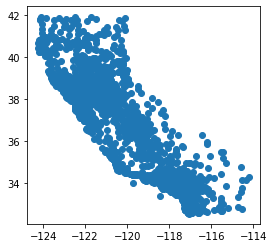

In [109]:
ca_zips_point_merged.plot()

### Export merged points geodataframe as GeoJSON

In [110]:
ca_zips_point_merged.head(5)

,zip,city,state,geometry,battery_electric,diesel_and_diesel_hybrid,flex_fuel,gasoline,hybrid_gasoline,other,plug_in_hybrid,total,winner,altshare,batteryshare
0,90001,Los Angeles,CA,POINT (-118.24 33.97),10,100,810,15374,413,2,44,16753,Flex fuel,8.00,0.06
1,90002,Los Angeles,CA,POINT (-118.24 33.94),22,48,748,14097,386,0,27,15328,Flex fuel,8.00,0.14
2,90003,Los Angeles,CA,POINT (-118.27 33.96),16,56,880,18487,522,6,39,20006,Flex fuel,8.00,0.08
3,90004,Los Angeles,CA,POINT (-118.31 34.07),248,107,442,19917,1878,14,251,22857,Hybrid gasoline,13.00,1.09
4,90005,Los Angeles,CA,POINT (-118.31 34.05),71,45,216,11043,857,6,105,12343,Hybrid gasoline,11.00,0.58


In [111]:
ca_zips_point_merged.to_file('/Users/mhustiles/data/data/fuel/ca_zips_point_merged.geojson', driver='GeoJSON')

### Convert polygons to mbtiles for Mapbox. Export.

In [112]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson

For layer 0, using name "ca_zips_poly_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_poly_merged.geojson: No such file or directory
0 features, 10 bytes of geometry, 16 bytes of separate metadata, 0 bytes of string pool
Did not read any valid geometries


### Convert points to mbtiles for Mapbox. Export.

In [113]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.geojson

For layer 0, using name "ca_zips_point_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/ca_zips_point_merged.geojson: No such file or directory
0 features, 10 bytes of geometry, 16 bytes of separate metadata, 0 bytes of string pool
Did not read any valid geometries


### Convert Tesla polygons to mbtiles for Mapbox. Export.

In [114]:
!tippecanoe --force -r1 -pk -pf -Z5 -z13 -o \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/teslas_poly_merged.mbtiles \
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/teslas_poly_merged.geojson

For layer 0, using name "teslas_poly_merged"
/Users/mhustiles/data/github/notebooks/california-fuel-vehicles/output/teslas_poly_merged.geojson: No such file or directory
0 features, 10 bytes of geometry, 16 bytes of separate metadata, 0 bytes of string pool
Did not read any valid geometries


---

## Waffle plot

In [137]:
fuel.head(9)

,fuel,vehicles,per_10000,per_1000
0,Battery Electric,214056,113.19,11.32
1,Diesel and Diesel Hybrid,319455,168.92,16.89
2,Flex-Fuel,993727,525.47,52.55
3,Gasoline,16175196,"8,553.27",855.33
4,Hybrid Gasoline,994696,525.98,52.60
5,Hydrogen Fuel Cell,5092,2.69,0.27
6,Natural Gas,6569,3.47,0.35
7,Other,368,0.19,0.02
8,Plug-in Hybrid,201969,106.80,10.68


In [138]:
fuel.vehicles.sum()

18911128

In [139]:
fuel.iloc[0,1] + fuel.iloc[5,1] + fuel.iloc[6,1] + fuel.iloc[7,1]

226085

In [140]:
fuel['per_1000'] =  ((fuel['vehicles'] / 18911128) * 1000).round(2)

In [141]:
fuel

,fuel,vehicles,per_10000,per_1000
0,Battery Electric,214056,113.19,11.32
1,Diesel and Diesel Hybrid,319455,168.92,16.89
2,Flex-Fuel,993727,525.47,52.55
3,Gasoline,16175196,"8,553.27",855.33
4,Hybrid Gasoline,994696,525.98,52.60
5,Hydrogen Fuel Cell,5092,2.69,0.27
6,Natural Gas,6569,3.47,0.35
7,Other,368,0.19,0.02
8,Plug-in Hybrid,201969,106.80,10.68


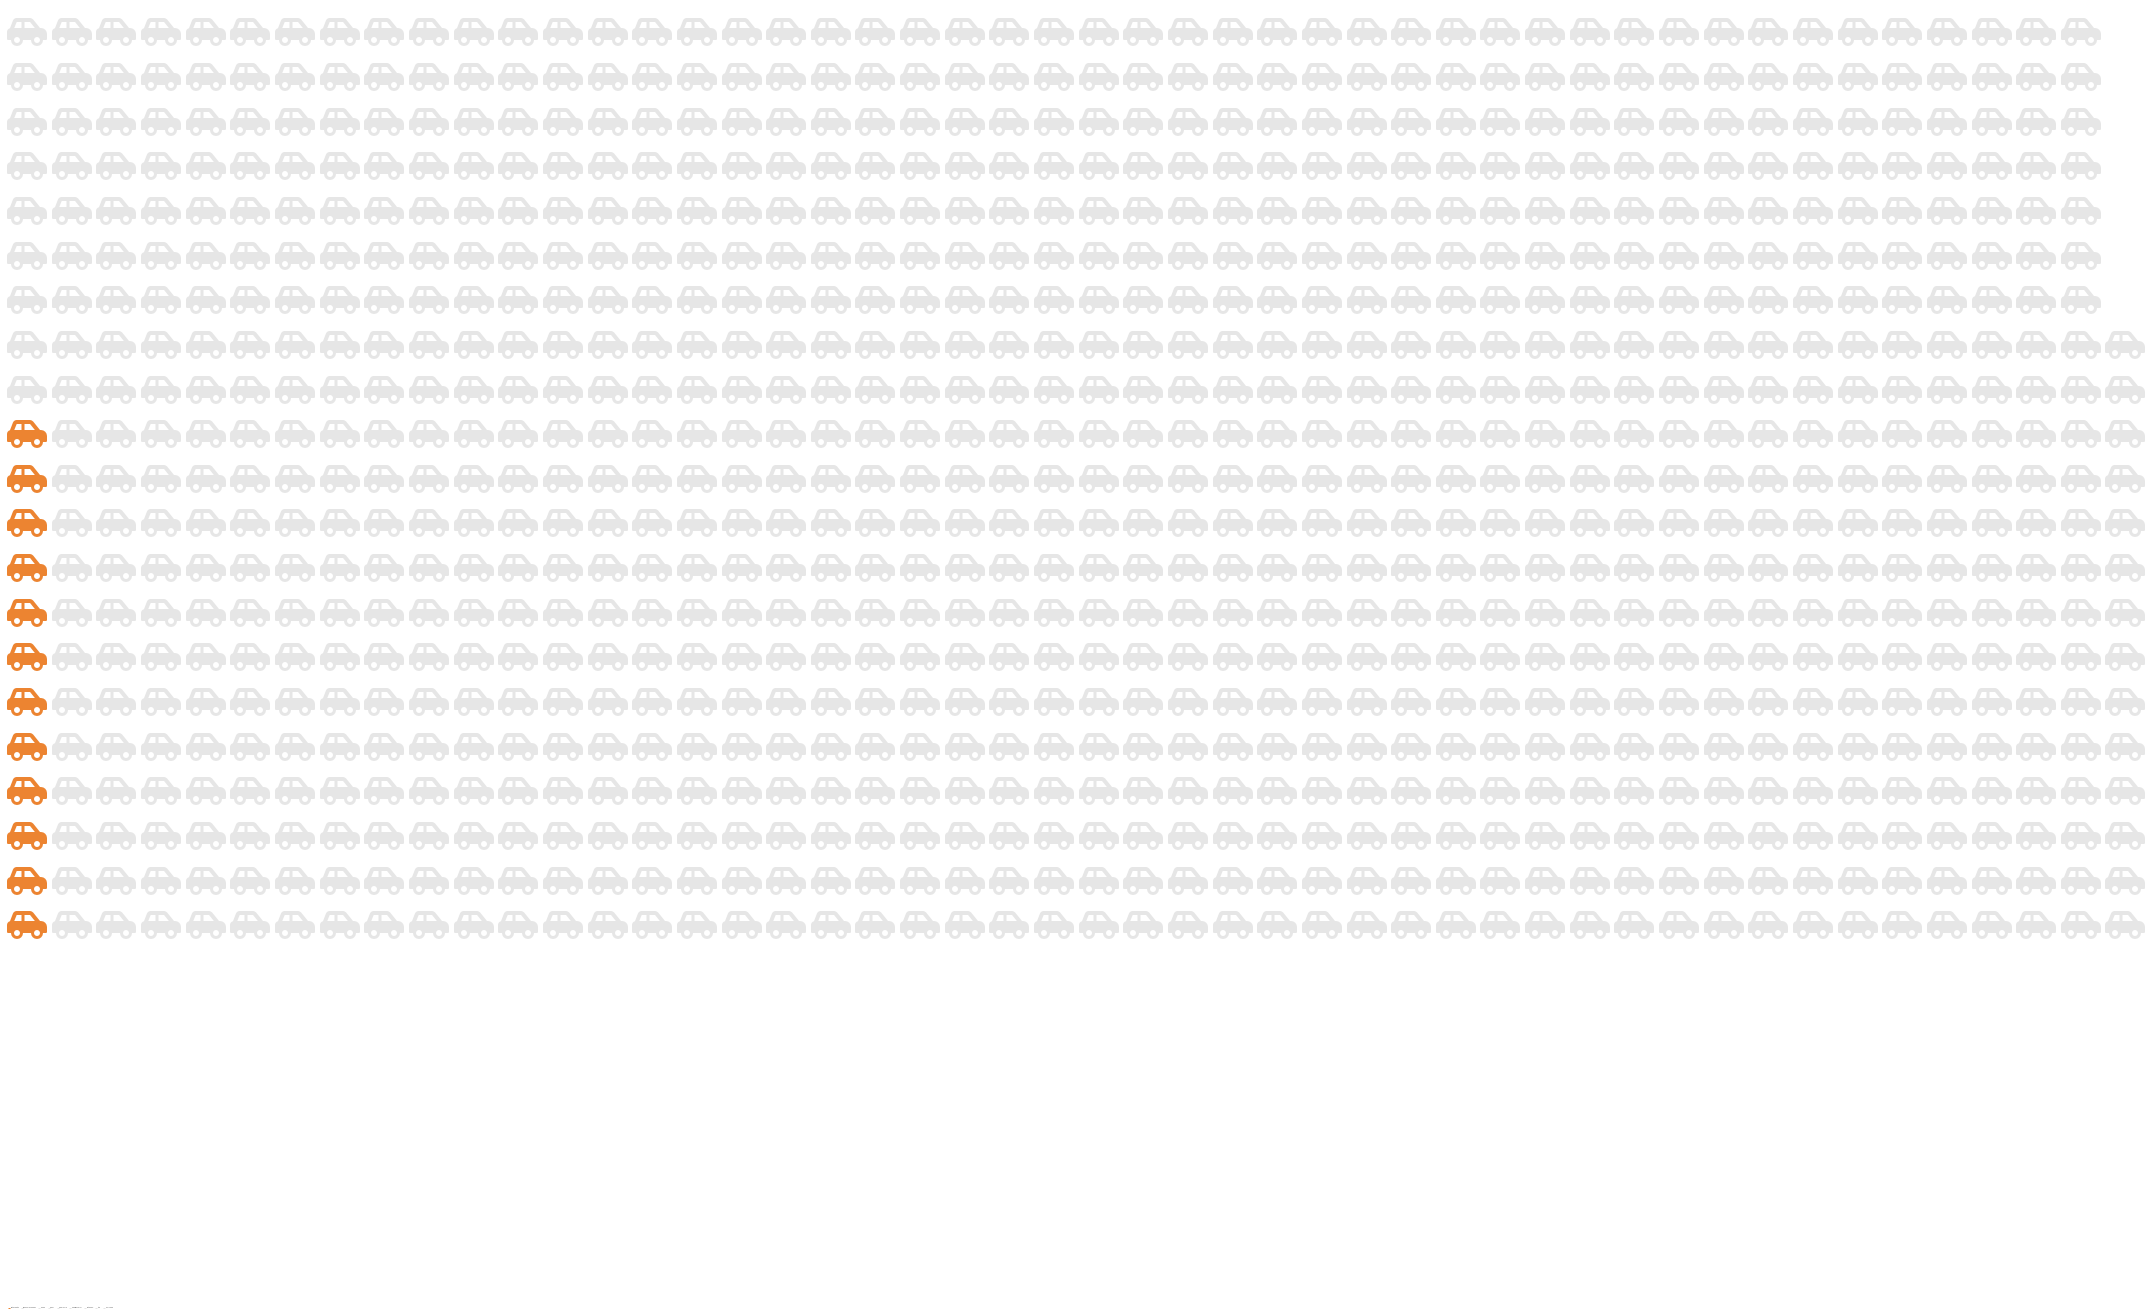

In [142]:
fig = plt.figure(
    FigureClass=Waffle, 
    rows=21,
    values=fuel.per_1000,
    labels=list(fuel.fuel),
    figsize=(30,20),
    icons='car-side',
    colors=['#ec8431','#e6e6e6','#e6e6e6','#e6e6e6','#e6e6e6','#e6e6e6','#e6e6e6', '#e6e6e6', '#e6e6e6'],
    legend={
        'loc': 'lower left',
        'bbox_to_anchor': (0, -0.4),
        'ncol': len(fuel),
        'framealpha': 0,
        'fontsize': 0
    }
)

See related [Twitter thread](https://twitter.com/stiles/status/1193416749116358656)